# Installation

In [1]:
!pip install ultralytics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.7 MB/s eta 0:00:00


# Vérification avant de commencer

In [2]:
import ultralytics

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
ultralytics.checks()

Ultralytics 8.3.140 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.5/112.6 GB disk)


Visualisation des ressources et utilisation GPU

In [4]:
!nvidia-smi

Tue May 20 11:16:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Vérification disponibilité GPU

In [5]:
import torch
print("GPU disponible :", torch.cuda.is_available())

GPU disponible : True


# Préparation du dataset

In [6]:
!unzip -q /content/data.zip -d /content/custom_data_raw

## Organisation à avoir

```
custom_data/
├── images/
│   ├── train/
│   └── val/
├── labels/
│   ├── train/
│   └── val/


## Réorganisation du dataset

In [7]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Répertoire d'origine pour les images et annotations
raw_data_path_images = "/content/custom_data_raw/images"  # Images sont dans ce dossier
raw_data_path_labels = "/content/custom_data_raw/obj_train_data"  # Annotations dans ce dossier

# Obtenir toutes les images (jpg/png) présentes dans le dossier "images"
images = [f for f in os.listdir(raw_data_path_images) if f.endswith(('.jpg', '.png'))]

# Split train/val (80% train, 20% val)
train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

# Création des dossiers cible pour images et labels
base_path = "/content/custom_data"


os.makedirs(base_path + "/images/train", exist_ok=True)
os.makedirs(base_path + "/images/val", exist_ok=True)
os.makedirs(base_path + "/labels/train", exist_ok=True)
os.makedirs(base_path + "/labels/val", exist_ok=True)

def move_data(image_list, split):
    for img_name in image_list:
        # Déplacer l'image vers le bon dossier
        src_img = os.path.join(raw_data_path_images, img_name)
        dst_img = os.path.join(base_path, f"images/{split}", img_name)
        shutil.copy(src_img, dst_img)

        # Vérifier et déplacer l'annotation .txt correspondante
        txt_name = img_name.rsplit('.', 1)[0] + '.txt'
        txt_src = os.path.join(raw_data_path_labels, txt_name)
        txt_dst = os.path.join(base_path, f"labels/{split}", txt_name)

        if os.path.exists(txt_src):
            shutil.copy(txt_src, txt_dst)
        else:
            print(f"Pas d'annotation pour {img_name}")

# Appliquer le déplacement aux deux splits : train et val
move_data(train_imgs, "train")
move_data(val_imgs, "val")


# Augmentation


In [8]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import cv2
import os

# === PARAMÈTRES ===
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=20, p=0.3),
    A.RandomGamma(p=0.3)
    #A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.4)
])

# Tu appliques l'augmentation uniquement sur le dossier d'entraînement
augmented_path = "/content/custom_data_augmented/images/train"
augmented_label_path = "/content/custom_data_augmented/labels/train"
os.makedirs(augmented_path, exist_ok=True)
os.makedirs(augmented_label_path, exist_ok=True)

original_train_images_path = "/content/custom_data/images/train"
original_train_labels_path = "/content/custom_data/labels/train"

# Copie les fichiers originaux
for img_file in tqdm(os.listdir(original_train_images_path), desc="Copie des images originales"):
    if not img_file.endswith(('.jpg', '.png')):
        continue
    img_path = os.path.join(original_train_images_path, img_file)
    label_path = os.path.join(original_train_labels_path, img_file.replace('.jpg', '.txt').replace('.png', '.txt'))

    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    # Sauvegarde originale
    cv2.imwrite(os.path.join(augmented_path, img_file), img)
    shutil.copy(label_path, os.path.join(augmented_label_path, os.path.basename(label_path)))

    # Augmente 2 fois chaque image
    for i in range(2):
        augmented = augmentations(image=img)["image"]
        aug_img_name = img_file.replace('.', f'_aug{i}.')
        aug_lbl_name = img_file.replace('.jpg', f'_aug{i}.txt').replace('.png', f'_aug{i}.txt')

        cv2.imwrite(os.path.join(augmented_path, aug_img_name), augmented)
        shutil.copy(label_path, os.path.join(augmented_label_path, aug_lbl_name))

print("✅ Dataset augmenté.")


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
Copie des images originales: 100%|██████████| 36/36 [00:14<00:00,  2.44it/s]

✅ Dataset augmenté.


In [9]:
# Copie val original sans modification
original_val_images_path = "/content/custom_data/images/val"
original_val_labels_path = "/content/custom_data/labels/val"

val_img_out_dir = "/content/custom_data_augmented/images/val"
val_lbl_out_dir = "/content/custom_data_augmented/labels/val"

os.makedirs(val_img_out_dir, exist_ok=True)
os.makedirs(val_lbl_out_dir, exist_ok=True)

for img_file in os.listdir(original_val_images_path):
    if not img_file.endswith(('.jpg', '.png')):
        continue

    img_src = os.path.join(original_val_images_path, img_file)
    lbl_src = os.path.join(original_val_labels_path, img_file.replace('.jpg', '.txt').replace('.png', '.txt'))

    img_dst = os.path.join(val_img_out_dir, img_file)
    lbl_dst = os.path.join(val_lbl_out_dir, os.path.basename(lbl_src))

    shutil.copy(img_src, img_dst)
    shutil.copy(lbl_src, lbl_dst)

print("✅ Validation copiée sans modification.")


✅ Validation copiée sans modification.


# Split des images du dataset

In [10]:
import os
import cv2
import shutil

# === PARAMÈTRES ===
# input_root = "/content/custom_data"
input_root = "/content/custom_data_augmented"

output_root = "/content/split_custom_data"

base_split_path = "/content/split_custom_data"

tile_size = 640
overlap = 0

splits = ["train", "val"]

def yolo_to_bbox(x_center, y_center, w, h, img_w, img_h):
    x1 = int((x_center - w / 2) * img_w)
    y1 = int((y_center - h / 2) * img_h)
    x2 = int((x_center + w / 2) * img_w)
    y2 = int((y_center + h / 2) * img_h)
    return x1, y1, x2, y2

def bbox_to_yolo(x1, y1, x2, y2, tile_w, tile_h):
    x_center = (x1 + x2) / 2 / tile_w
    y_center = (y1 + y2) / 2 / tile_h
    w = (x2 - x1) / tile_w
    h = (y2 - y1) / tile_h
    return x_center, y_center, w, h

# Boucle sur train et val
for split in splits:
    input_img_dir = os.path.join(input_root, f"images/{split}")
    input_lbl_dir = os.path.join(input_root, f"labels/{split}")
    output_img_dir = os.path.join(output_root, f"images/{split}")
    output_lbl_dir = os.path.join(output_root, f"labels/{split}")

    os.makedirs(output_img_dir, exist_ok=True)
    os.makedirs(output_lbl_dir, exist_ok=True)

    for filename in os.listdir(input_img_dir):
        if not filename.lower().endswith(('.jpg', '.png')):
            continue

        basename = os.path.splitext(filename)[0]
        img_path = os.path.join(input_img_dir, filename)
        label_path = os.path.join(input_lbl_dir, f"{basename}.txt")

        img = cv2.imread(img_path)
        img_h, img_w = img.shape[:2]

        annotations = []
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    if len(parts) == 5:
                        cls, xc, yc, w, h = map(float, parts)
                        annotations.append((cls, *yolo_to_bbox(xc, yc, w, h, img_w, img_h)))

        step = tile_size - overlap
        tile_id = 0

        for y in range(0, img_h, step):
            for x in range(0, img_w, step):
                tile = img[y:y + tile_size, x:x + tile_size]
                tile_h, tile_w = tile.shape[:2]

                if tile_h < tile_size or tile_w < tile_size:
                    continue

                tile_filename = f"{basename}_{tile_id}.jpg"
                label_filename = f"{basename}_{tile_id}.txt"
                tile_id += 1

                cv2.imwrite(os.path.join(output_img_dir, tile_filename), tile)

                new_annots = []
                for cls, x1, y1, x2, y2 in annotations:
                    if x1 >= x + tile_size or x2 <= x or y1 >= y + tile_size or y2 <= y:
                        continue

                    bx1 = max(0, x1 - x)
                    by1 = max(0, y1 - y)
                    bx2 = min(tile_size, x2 - x)
                    by2 = min(tile_size, y2 - y)

                    if bx2 - bx1 < 5 or by2 - by1 < 5:
                        continue

                    x_c, y_c, w, h = bbox_to_yolo(bx1, by1, bx2, by2, tile_size, tile_size)
                    new_annots.append(f"{int(cls)} {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}")

                with open(os.path.join(output_lbl_dir, label_filename), "w") as f:
                    f.write("\n".join(new_annots))

    print(f"✅ Split terminé pour '{split}' — {len(os.listdir(output_img_dir))} tuiles générées")


✅ Split terminé pour 'train' — 1992 tuiles générées
✅ Split terminé pour 'val' — 180 tuiles générées


# HSV

In [11]:
import os
import cv2
from tqdm import tqdm

input_root = "/content/split_custom_data/images"
output_root = "/content/split_custom_data_hsv/images"

splits = ["train", "val"]

for split in splits:
    in_dir = os.path.join(input_root, split)
    out_dir = os.path.join(output_root, split)
    os.makedirs(out_dir, exist_ok=True)

    for img_file in tqdm(os.listdir(in_dir), desc=f"Conversion HSV - {split}"):
        if not img_file.lower().endswith(('.jpg', '.png')):
            continue

        img_path = os.path.join(in_dir, img_file)
        img = cv2.imread(img_path)  # BGR
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        out_path = os.path.join(out_dir, img_file)
        cv2.imwrite(out_path, hsv)


Conversion HSV - val: 100%|██████████| 180/180 [00:01<00:00, 106.17it/s]


In [12]:
import shutil

label_input_root = "/content/split_custom_data/labels"
label_output_root = "/content/split_custom_data_hsv/labels"

splits = ["train", "val"]
for split in splits:
    in_dir = os.path.join(label_input_root, split)
    out_dir = os.path.join(label_output_root, split)
    os.makedirs(out_dir, exist_ok=True)

    for label_file in os.listdir(in_dir):
        if label_file.endswith(".txt"):
            shutil.copy(os.path.join(in_dir, label_file), os.path.join(out_dir, label_file))

print("✅ Labels copiés vers le dossier HSV.")


✅ Labels copiés vers le dossier HSV.


# Génération des YAML

Dynamique :

In [13]:
# Chemin vers le fichier obj.names exporté par CVAT (modifie si besoin)
obj_names_path = "/content/custom_data_raw/obj.names"

# Lire les noms de classes depuis obj.names
with open(obj_names_path, 'r') as f:
    class_names = [line.strip() for line in f if line.strip()]

# Générer le contenu du fichier YAML avec les augmentations de couleur
yaml_content = f"""
path: {base_split_path}
train: images/train
val: images/val
nc: {len(class_names)}
names: {class_names}
augment: True  # Activer l'augmentation des données
auto_augment: albumentations



# weights: [0.9, 0.1]  # Exemple de pondération si olive est trop présente
"""


# Écriture du fichier data.yaml
with open(f"{base_path}/data.yaml", "w") as f:
    f.write(yaml_content.strip())

with open(f"{base_split_path}/data.yaml", "w") as f:
    f.write(yaml_content.strip())

print(" Fichier data.yaml généré automatiquement :")
print(yaml_content)


 Fichier data.yaml généré automatiquement :

path: /content/split_custom_data
train: images/train
val: images/val
nc: 2
names: ['olive', 'potential_olive']
augment: True  # Activer l'augmentation des données
auto_augment: albumentations



# weights: [0.9, 0.1]  # Exemple de pondération si olive est trop présente



In [14]:
custom_train_cfg = """
# train_custom.yaml — Configuration d'entraînement pour YOLOv8

# Chemins
data: /content/split_custom_data/data.yaml
model: yolov8m.pt
# model: yolo11x.pt

# Entraînement
epochs: 30
batch: 16
imgsz: 320
device: 0
patience: 10  # arrête si la val n'évolue plus pendant 10 epochs

# Hyperparamètres généraux
optimizer: SGD
lr0: 0.001
lrf: 0.01




# Augmentations géométriques
degrees: 00.0
translate: 0.0
scale: 0.5
shear: 0.0
perspective: 0.0
flipud: 0.0
fliplr: 0.5

# Augmentations de couleur (adapté olives/feuillage)
hsv_h: 0.02
hsv_s: 0.6
hsv_v: 0.5

# Avancées
mosaic: 0.3
mixup: 0.1
copy_paste: 0.6

# auto_augment: randaugment
auto_augment: albumentations

"""

# Écriture du fichier YAML
with open("/content/custom_data/train_custom.yaml", "w") as f:
    f.write(custom_train_cfg.strip())

print("✅ Fichier train_custom.yaml généré.")

with open(f"/content/split_custom_data/train_custom.yaml", "w") as f:
    f.write(custom_train_cfg.strip())

print("✅ Fichier train_custom.yaml généré.")


✅ Fichier train_custom.yaml généré.
✅ Fichier train_custom.yaml généré.


## Vérification des labels et autres

In [15]:
import os
from collections import Counter

# Dictionnaire des classes : adapte-le si jamais tu changes l'ordre ou les noms
class_names = {
    '0': 'olive',
    '1': 'potential_olive'
}

def analyze_labels(labels_dir):
    label_counts = Counter()

    for split in ['train', 'val']:
        dir_path = os.path.join(labels_dir, split)
        for file in os.listdir(dir_path):
            if file.endswith('.txt'):
                with open(os.path.join(dir_path, file), 'r') as f:
                    for line in f:
                        if line.strip():
                            class_id = line.strip().split()[0]
                            label_counts[class_id] += 1

    print(" Résumé des classes dans les annotations :\n")
    for class_id, count in label_counts.items():
        class_name = class_names.get(class_id, " Inconnu")
        print(f"Classe {class_id} ({class_name}) → {count} objets")

    # Alerte pour les classes non attendues
    for cid in label_counts:
        if cid not in class_names:
            print(f"\n ID inattendu détecté : {cid}")

# Appel de la fonction
analyze_labels(f"{base_split_path}/labels")


 Résumé des classes dans les annotations :

Classe 0 (olive) → 7172 objets
Classe 1 (potential_olive) → 21 objets


# Train COCO RGB

In [16]:
from ultralytics import YOLO

model = YOLO("yolov8x.pt")  # ou un autre modèle préentraîné

# Geler les premières couches
#for param in model.model.model[0].parameters():
    #param.requires_grad = False



# Geler les 2 ou 3 premiers blocs du backbone (en général C1, C2, C3)
# for i, (name, module) in enumerate(model.model.model[0].named_children()):
   # if i < 3:  # essaie 2, 3 ou 4
       # for param in module.parameters():
           # param.requires_grad = False


model.train(
    data=f"{base_split_path}/data.yaml",
    epochs=30,
    device=0,
    batch=16,
    imgsz=640,
    patience=15,
    optimizer='SGD',
    lr0=0.001,
    lrf=0.01,
    degrees=0.0,
    translate=0.0,
    scale=0.5,
    shear=0.0,
    perspective=0.0,
    flipud=0.0,
    fliplr=0.5,
    hsv_h=0.02,
    hsv_s=0.6,
    hsv_v=0.5,
    mosaic=0.6,
    mixup=0.1,
    copy_paste=0.7,
    auto_augment='albumentations'
)


100%|██████████| 131M/131M [00:00<00:00, 228MB/s]


Ultralytics 8.3.140 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=albumentations, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.7, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/split_custom_data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.02, hsv_s=0.6, hsv_v=0.5, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8x.pt, momentum=0.937, mosaic=0.6, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patience=15, perspective=0.0, plots=True, pose=12.0, pret

100%|██████████| 755k/755k [00:00<00:00, 15.0MB/s]

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              


  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytics.nn.modules.conv.Conv             [640, 640, 3, 2]              
  8                  -1  3   6969600  ultralytics.nn.modules.block.C2f             [640, 640, 3, True]           
  9                  -1  1   1025920  ultralytics.nn.modules.block.SPPF            [640, 640, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  3   7379200  ultralytics.nn.modules.block.C2f             [1280, 640, 3]                
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

100%|██████████| 5.35M/5.35M [00:00<00:00, 65.9MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2071.4±1502.9 MB/s, size: 237.0 KB)


train: Scanning /content/split_custom_data/labels/train... 1992 images, 1223 backgrounds, 0 corrupt: 100%|██████████| 1992/1992 [00:00<00:00, 2996.29it/s]

train: New cache created: /content/split_custom_data/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1553.8±926.3 MB/s, size: 228.4 KB)


val: Scanning /content/split_custom_data/labels/val... 180 images, 108 backgrounds, 0 corrupt: 100%|██████████| 180/180 [00:00<00:00, 1708.37it/s]

val: New cache created: /content/split_custom_data/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      11.8G      2.135      4.042      1.404          3        640: 100%|██████████| 125/125 [02:42<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.24s/it]

                   all        180        434      0.609      0.546      0.565      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      11.8G      1.771      2.175      1.254         49        640: 100%|██████████| 125/125 [02:45<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

                   all        180        434      0.606      0.659      0.651      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30        12G      1.697      2.019      1.194         20        640: 100%|██████████| 125/125 [02:44<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]

                   all        180        434      0.698      0.611      0.661      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      12.2G      1.612      1.834      1.132         28        640: 100%|██████████| 125/125 [02:44<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.00s/it]

                   all        180        434      0.668      0.629      0.693      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      12.2G      1.594      1.772      1.125          6        640: 100%|██████████| 125/125 [02:44<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

                   all        180        434      0.644      0.687      0.712      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      11.9G       1.51      1.568      1.079         31        640: 100%|██████████| 125/125 [02:44<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]

                   all        180        434       0.69      0.657      0.702      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      12.2G      1.623       1.74      1.128         74        640: 100%|██████████| 125/125 [02:44<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]

                   all        180        434      0.628      0.699      0.702      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      12.1G      1.532      1.605      1.095         16        640: 100%|██████████| 125/125 [02:44<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]

                   all        180        434      0.691      0.657      0.726      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      12.2G       1.58      1.704      1.094         47        640: 100%|██████████| 125/125 [02:44<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

                   all        180        434      0.617      0.721      0.725      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      11.9G      1.475      1.521      1.056         20        640: 100%|██████████| 125/125 [02:43<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

                   all        180        434      0.629      0.684      0.699      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      12.2G       1.49      1.574      1.067         69        640: 100%|██████████| 125/125 [02:44<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.06s/it]

                   all        180        434      0.696      0.643      0.693      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      12.2G      1.446      1.459      1.046         33        640: 100%|██████████| 125/125 [02:44<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.00s/it]

                   all        180        434      0.678      0.654      0.705       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      12.2G      1.507      1.574      1.067         54        640: 100%|██████████| 125/125 [02:44<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.00s/it]

                   all        180        434      0.666       0.72      0.739      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30        12G      1.402      1.425      1.035         12        640: 100%|██████████| 125/125 [02:44<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

                   all        180        434      0.661      0.694      0.731      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      12.2G      1.468      1.513      1.068         15        640: 100%|██████████| 125/125 [02:44<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]

                   all        180        434      0.683      0.699      0.751      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      12.2G       1.43      1.505      1.038          7        640: 100%|██████████| 125/125 [02:44<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]

                   all        180        434      0.676      0.696      0.727      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      12.2G      1.395      1.345       1.02         14        640: 100%|██████████| 125/125 [02:44<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]

                   all        180        434      0.658      0.719      0.708      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30        12G      1.365      1.372      1.031         19        640: 100%|██████████| 125/125 [02:44<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.00it/s]

                   all        180        434      0.705      0.704      0.739      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      12.2G      1.424      1.437      1.048         22        640: 100%|██████████| 125/125 [02:44<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

                   all        180        434      0.695      0.705      0.743      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      12.2G       1.38      1.341      1.029         35        640: 100%|██████████| 125/125 [02:45<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]

                   all        180        434      0.716      0.668      0.744      0.473


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      12.2G      1.381      1.382      1.036         33        640: 100%|██████████| 125/125 [02:44<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.00s/it]

                   all        180        434      0.659      0.709      0.729      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30        12G      1.394       1.53      1.034          3        640: 100%|██████████| 125/125 [02:43<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

                   all        180        434      0.659      0.673      0.727      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      12.2G      1.337      1.449      1.022          0        640: 100%|██████████| 125/125 [02:43<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

                   all        180        434      0.645      0.749      0.743      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      12.2G      1.392      1.418      1.051         23        640: 100%|██████████| 125/125 [02:43<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.00s/it]

                   all        180        434      0.643      0.781      0.765      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      12.2G      1.401      1.442       1.03         15        640: 100%|██████████| 125/125 [02:43<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

                   all        180        434      0.644      0.758      0.761      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30        12G      1.348      1.337      1.021         20        640: 100%|██████████| 125/125 [02:43<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

                   all        180        434      0.714      0.684       0.76       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      12.1G      1.341      1.509       1.02         23        640: 100%|██████████| 125/125 [02:42<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.00it/s]

                   all        180        434      0.664      0.749      0.755      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      12.2G      1.284      1.206     0.9978          8        640: 100%|██████████| 125/125 [02:42<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

                   all        180        434      0.652      0.742      0.748      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      12.2G      1.326      1.292      1.035         67        640: 100%|██████████| 125/125 [02:43<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.03it/s]

                   all        180        434      0.654      0.731      0.751      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30        12G       1.29      1.239       1.02         31        640: 100%|██████████| 125/125 [02:42<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

                   all        180        434      0.672      0.726      0.752      0.471



30 epochs completed in 1.477 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 136.7MB
Optimizer stripped from runs/detect/train/weights/best.pt, 136.7MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.140 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 68,125,494 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.19s/it]


                   all        180        434      0.642      0.781      0.765      0.487
                 olive         72        434      0.642      0.781      0.765      0.487
Speed: 0.3ms preprocess, 29.1ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78b704193a10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [17]:
model.save("last_rgb_model.pt")

# Train COCO HSV


In [18]:
model = YOLO("/content/last_rgb_model.pt") # Load your RGB-finetuned model
model.train(
data="/content/split_custom_data_hsv/data.yaml", # split_data_hsv
epochs=50,
imgsz=640,
lr0=1e-4, # Smaller LR for stable adaptation
hsv_h=0.0, # Disable built-in HSV augmentation (use true HSV images)
pretrained=False # Avoid resetting weights to COCO defaults
)

Ultralytics 8.3.140 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/split_custom_data_hsv/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/last_rgb_model.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=T

train: Scanning /content/split_custom_data_hsv/labels/train... 1992 images, 1223 backgrounds, 0 corrupt: 100%|██████████| 1992/1992 [00:04<00:00, 443.24it/s]


train: New cache created: /content/split_custom_data_hsv/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 46.5±10.6 MB/s, size: 233.9 KB)


val: Scanning /content/split_custom_data_hsv/labels/val... 180 images, 108 backgrounds, 0 corrupt: 100%|██████████| 180/180 [00:00<00:00, 444.67it/s]


val: New cache created: /content/split_custom_data_hsv/labels/val.cache
Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      12.8G      1.991      2.398       1.22         22        640: 100%|██████████| 125/125 [02:46<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]

                   all        180        434      0.325      0.247      0.178     0.0892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      13.3G      2.194       2.61      1.302         43        640: 100%|██████████| 125/125 [02:41<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.00it/s]

                   all        180        434      0.428      0.329      0.243      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      12.3G       2.29        2.7      1.325         29        640: 100%|██████████| 125/125 [02:41<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.03it/s]

                   all        180        434      0.318       0.21      0.158     0.0807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      12.5G      2.277      2.781      1.304          4        640: 100%|██████████| 125/125 [02:42<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

                   all        180        434      0.319      0.237      0.187     0.0784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      12.5G       2.13      2.582      1.222         26        640: 100%|██████████| 125/125 [02:39<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.03it/s]

                   all        180        434      0.535      0.433      0.422      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      12.2G      2.041      2.355      1.207         44        640: 100%|██████████| 125/125 [02:40<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.02s/it]

                   all        180        434      0.565      0.507      0.527      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      12.5G      2.079      2.477      1.234         54        640: 100%|██████████| 125/125 [02:39<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]

                   all        180        434     0.0552      0.249     0.0339     0.0197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      12.5G      1.996      2.343      1.195          5        640: 100%|██████████| 125/125 [02:40<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.04s/it]

                   all        180        434      0.576      0.472      0.505      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      12.4G      1.982      2.289      1.175         27        640: 100%|██████████| 125/125 [02:40<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

                   all        180        434      0.609      0.544      0.579      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      12.3G      1.947      2.309      1.167          4        640: 100%|██████████| 125/125 [02:39<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.03it/s]

                   all        180        434      0.538      0.486      0.523      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      12.4G      1.929      2.176      1.162         32        640: 100%|██████████| 125/125 [02:39<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.00s/it]

                   all        180        434      0.525      0.468       0.48       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      12.5G      1.876      2.178      1.154         47        640: 100%|██████████| 125/125 [02:39<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.00s/it]

                   all        180        434      0.595      0.498      0.525      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      12.5G      1.851       2.12      1.132         32        640: 100%|██████████| 125/125 [02:39<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]

                   all        180        434      0.614      0.513      0.543      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      12.3G      1.886      2.207      1.167         29        640: 100%|██████████| 125/125 [02:39<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.02s/it]

                   all        180        434      0.634      0.537      0.577      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      12.5G      1.959      2.225       1.18         24        640: 100%|██████████| 125/125 [02:39<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.03it/s]

                   all        180        434      0.596      0.486      0.539      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      12.4G      1.837      2.112       1.15         10        640: 100%|██████████| 125/125 [02:39<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.00s/it]

                   all        180        434      0.661      0.585      0.613      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      12.5G      1.868      2.105      1.151         20        640: 100%|██████████| 125/125 [02:39<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

                   all        180        434      0.633      0.498      0.562      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      12.2G      1.812       2.07      1.158         25        640: 100%|██████████| 125/125 [02:39<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.00it/s]

                   all        180        434      0.602      0.555      0.563      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      12.5G      1.754      1.991      1.131         62        640: 100%|██████████| 125/125 [02:39<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]

                   all        180        434      0.638      0.539      0.585      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      12.5G      1.747      1.918      1.111         63        640: 100%|██████████| 125/125 [02:39<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]

                   all        180        434      0.511      0.498      0.461      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      12.5G      1.755      1.943       1.12         12        640: 100%|██████████| 125/125 [02:40<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

                   all        180        434      0.588      0.493      0.492      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      12.2G      1.714      1.966      1.115         59        640: 100%|██████████| 125/125 [02:39<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]

                   all        180        434      0.672      0.581      0.622      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      12.5G       1.74      2.037      1.113         65        640: 100%|██████████| 125/125 [02:39<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.03it/s]

                   all        180        434      0.651       0.65       0.63      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      12.5G      1.672      1.812      1.097         37        640: 100%|██████████| 125/125 [02:39<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]

                   all        180        434      0.601      0.507      0.551      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      12.5G      1.723      1.877       1.11         22        640: 100%|██████████| 125/125 [02:38<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.02s/it]

                   all        180        434       0.59      0.594      0.583      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      12.2G      1.739      1.941      1.099         25        640: 100%|██████████| 125/125 [02:39<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.03it/s]

                   all        180        434      0.613      0.561      0.596      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      12.5G      1.651      1.774      1.087         40        640: 100%|██████████| 125/125 [02:39<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]

                   all        180        434      0.683      0.615      0.659      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      12.5G      1.662      1.826      1.087         45        640: 100%|██████████| 125/125 [02:39<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]

                   all        180        434      0.639      0.611       0.62      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      12.5G      1.597      1.786      1.075         24        640: 100%|██████████| 125/125 [02:39<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.03it/s]

                   all        180        434      0.663      0.555      0.624      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      12.2G      1.597      1.768       1.07         56        640: 100%|██████████| 125/125 [02:39<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]

                   all        180        434      0.618      0.576      0.603      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      12.4G      1.593      1.694      1.069         49        640: 100%|██████████| 125/125 [02:40<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.00s/it]

                   all        180        434      0.614      0.567      0.601      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      12.5G      1.588      1.718      1.067         22        640: 100%|██████████| 125/125 [02:39<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.02s/it]

                   all        180        434      0.707      0.566      0.639      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      12.4G       1.66      1.842      1.087         33        640: 100%|██████████| 125/125 [02:39<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.03it/s]

                   all        180        434      0.649      0.525       0.57      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      12.2G      1.497      1.608      1.052         66        640: 100%|██████████| 125/125 [02:39<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.04it/s]

                   all        180        434      0.676      0.583      0.641      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      12.5G       1.59      1.719      1.073          8        640: 100%|██████████| 125/125 [02:39<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

                   all        180        434      0.699      0.572      0.668       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      12.4G      1.605      1.834      1.073         20        640: 100%|██████████| 125/125 [02:39<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.05s/it]

                   all        180        434      0.653      0.615      0.664      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      12.5G      1.576        1.7      1.076          9        640: 100%|██████████| 125/125 [02:39<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]

                   all        180        434      0.701      0.595      0.677      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      12.3G      1.601      1.763      1.071         20        640: 100%|██████████| 125/125 [02:39<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]

                   all        180        434      0.675      0.621      0.658      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      12.5G      1.517      1.649      1.047         18        640: 100%|██████████| 125/125 [02:39<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]

                   all        180        434      0.633      0.608      0.643      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      12.5G       1.47      1.617      1.031         32        640: 100%|██████████| 125/125 [02:39<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]

                   all        180        434      0.702      0.588      0.659      0.409


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      12.5G      1.563      1.962      1.092         22        640: 100%|██████████| 125/125 [02:38<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

                   all        180        434      0.684      0.578      0.647      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      12.3G      1.561      1.797      1.099          5        640: 100%|██████████| 125/125 [02:38<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.03it/s]

                   all        180        434      0.656      0.598      0.637      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      12.5G      1.528      1.782      1.073         50        640: 100%|██████████| 125/125 [02:38<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.03it/s]

                   all        180        434      0.699      0.576      0.634      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      12.4G      1.493      1.701      1.074         21        640: 100%|██████████| 125/125 [02:38<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

                   all        180        434      0.655      0.597      0.645      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      12.5G      1.539      1.832      1.075         20        640: 100%|██████████| 125/125 [02:39<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

                   all        180        434      0.719      0.578       0.67      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      12.2G      1.485      1.798      1.071         45        640: 100%|██████████| 125/125 [02:38<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]

                   all        180        434      0.733      0.551      0.646      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      12.5G      1.451      1.759      1.054         13        640: 100%|██████████| 125/125 [02:38<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]

                   all        180        434      0.642      0.583      0.648        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      12.5G      1.488      1.666      1.065         24        640: 100%|██████████| 125/125 [02:39<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.05s/it]

                   all        180        434      0.614      0.606      0.633      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      12.5G      1.442      1.658       1.06        111        640: 100%|██████████| 125/125 [02:38<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.03it/s]

                   all        180        434      0.657       0.56      0.639      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      12.2G       1.47      1.667      1.063         27        640: 100%|██████████| 125/125 [02:38<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.02s/it]

                   all        180        434       0.66      0.585      0.655      0.412



50 epochs completed in 2.501 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 136.7MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 136.7MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.140 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 68,125,494 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.08s/it]


                   all        180        434      0.703      0.571      0.668      0.429
                 olive         72        434      0.703      0.571      0.668      0.429
Speed: 0.2ms preprocess, 28.2ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78b6fbf911d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# Résultats

In [19]:
import glob
from IPython.display import Image, display

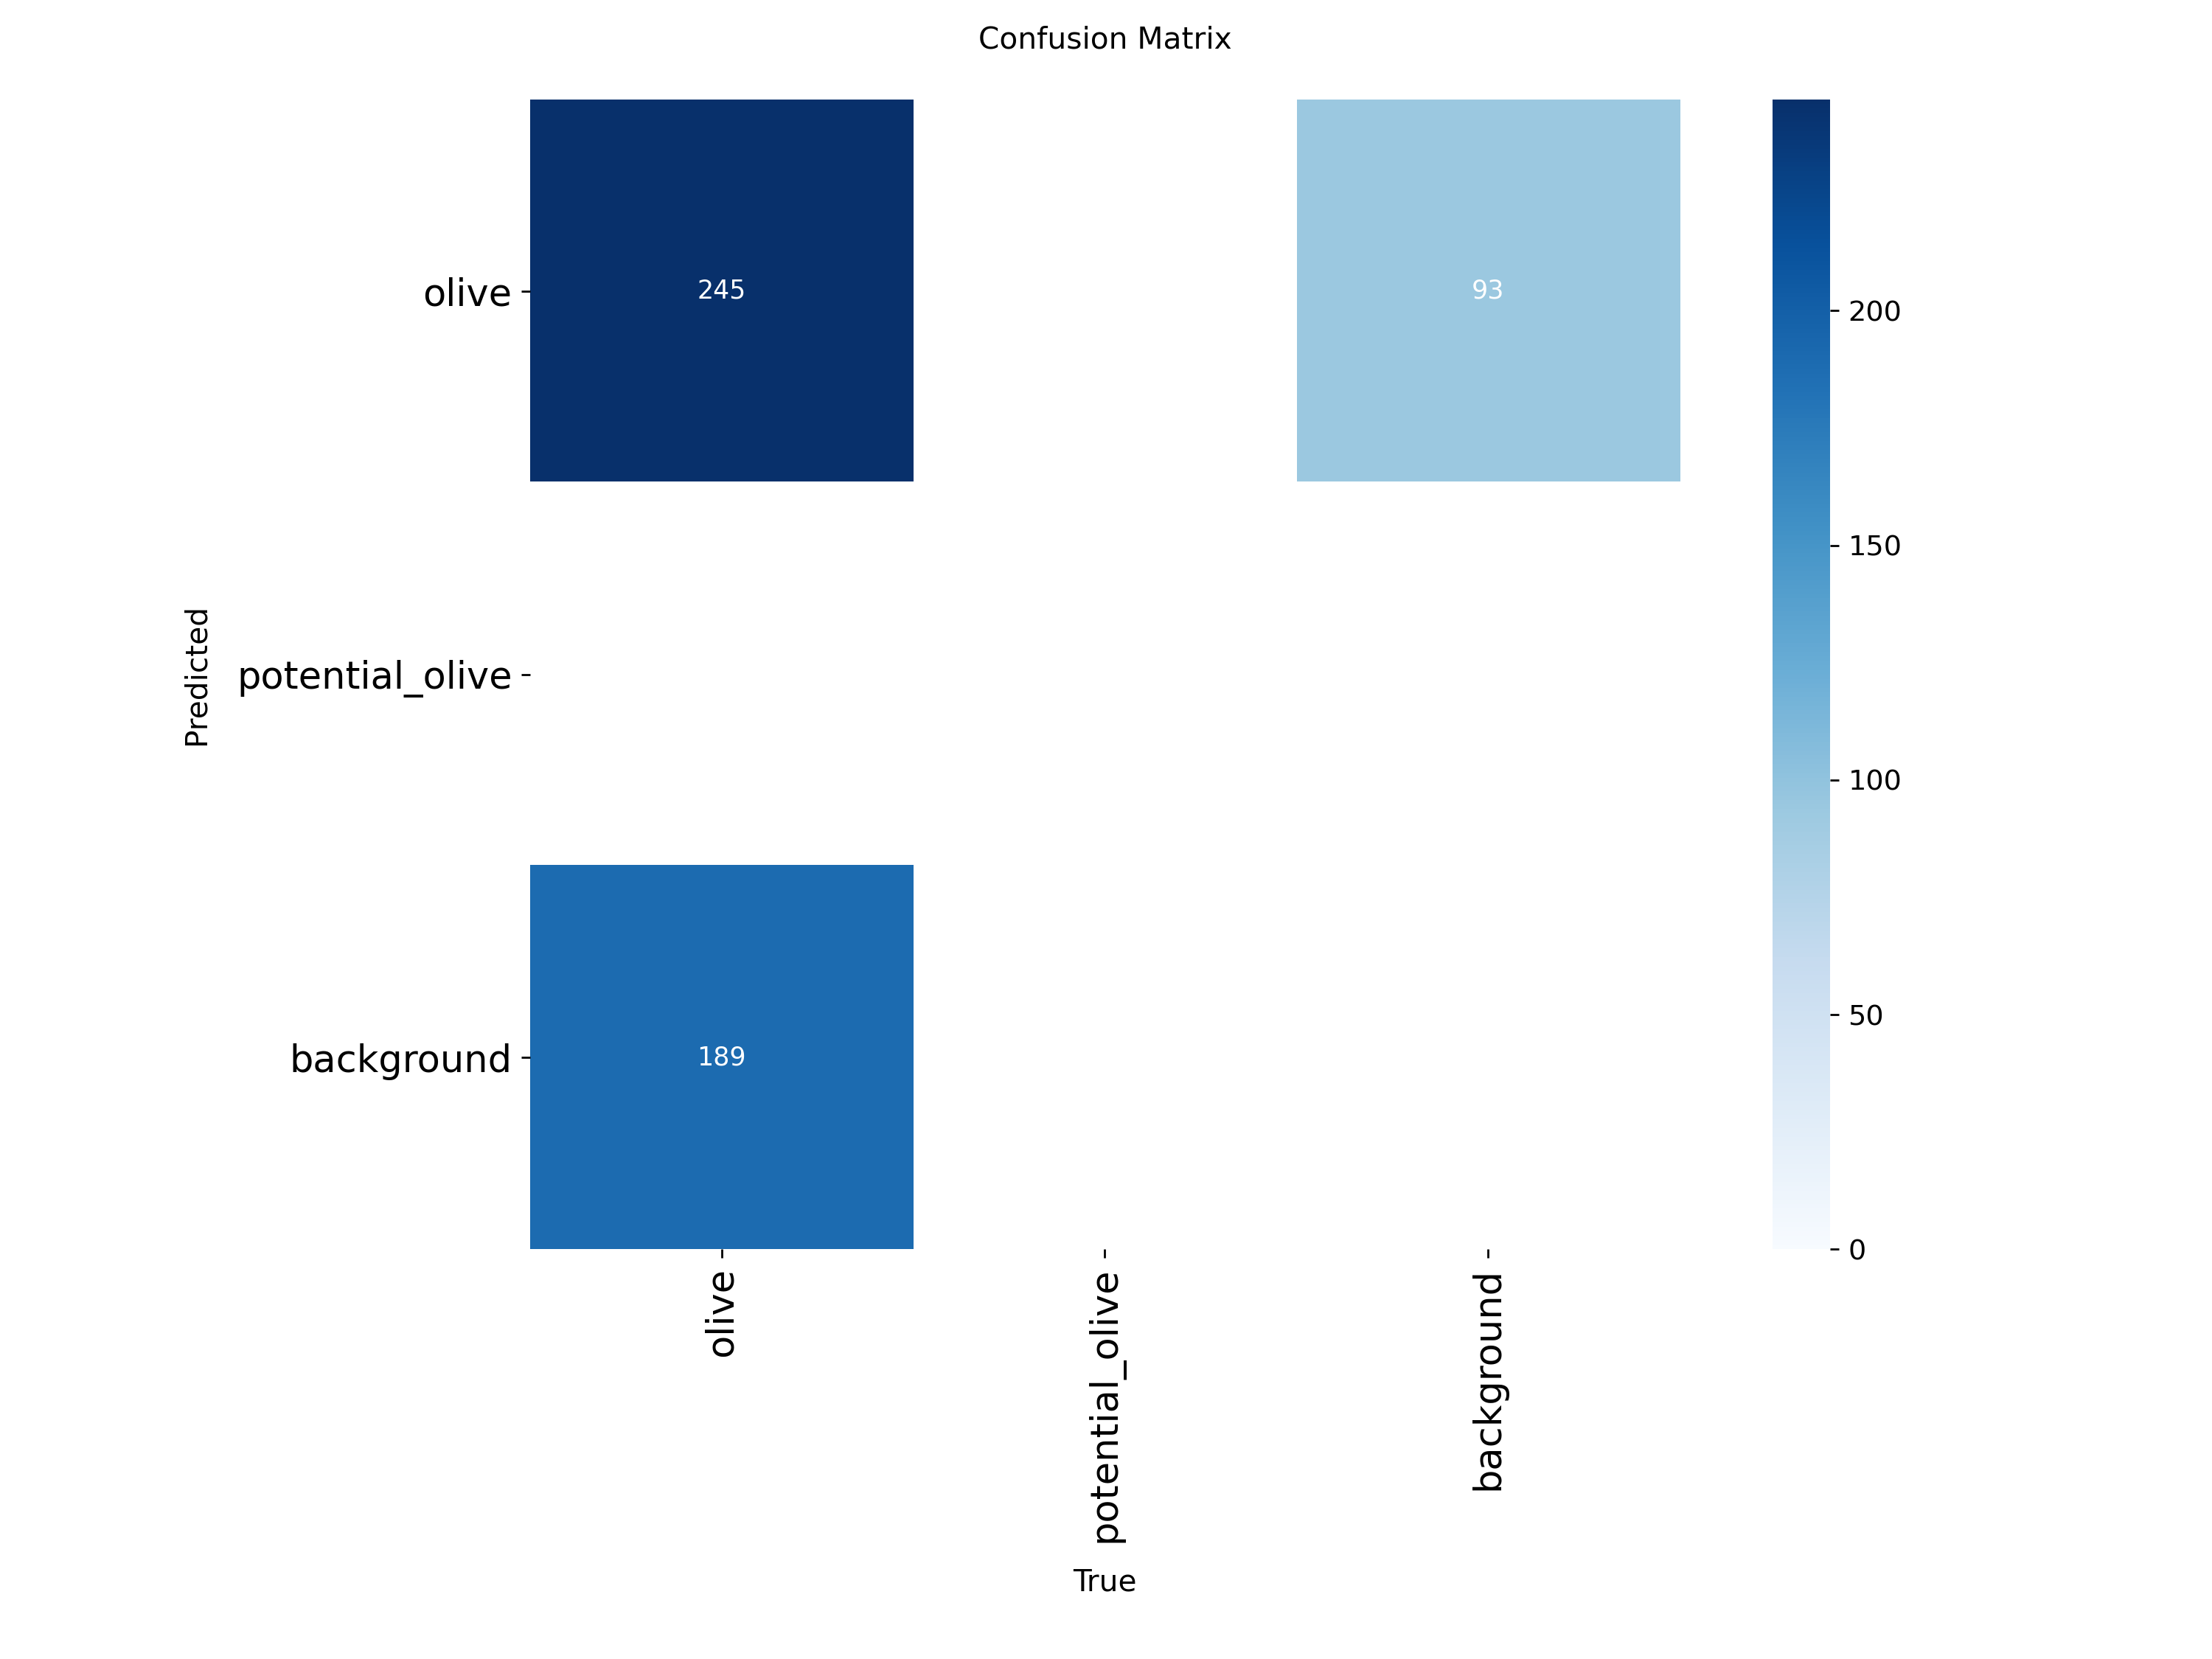

In [20]:
Image(filename='runs/detect/train2/confusion_matrix.png', width=600)

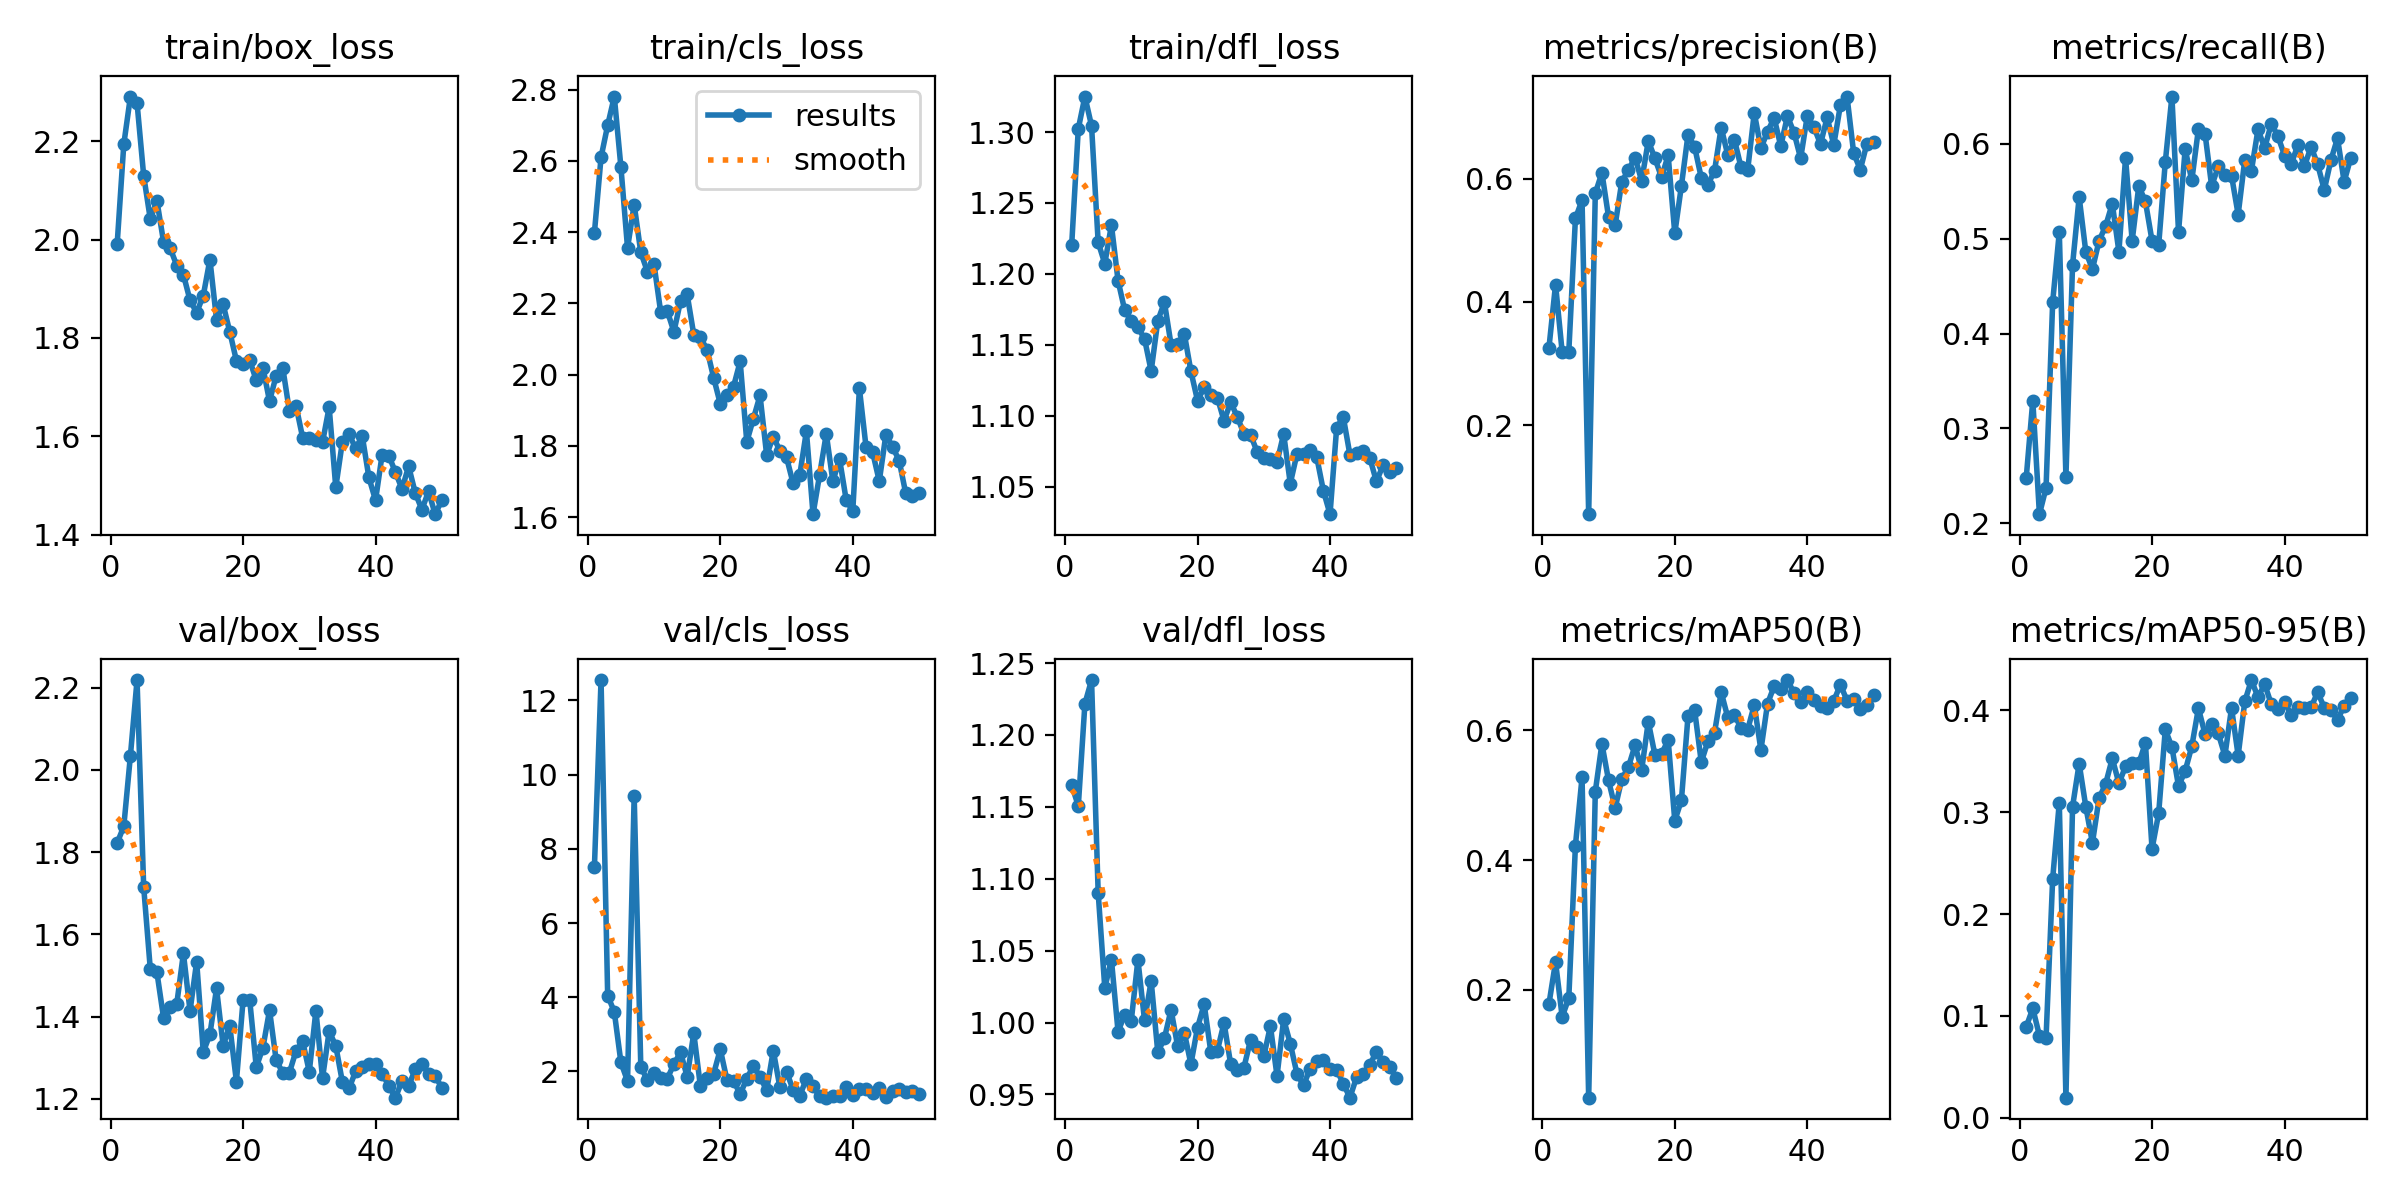

In [21]:
Image(filename='runs/detect/train2/results.png', width=600)

# Validation

In [23]:
from ultralytics import YOLO

# Charger le modèle entraîné
model = YOLO("runs/detect/train2/weights/best.pt")

# Évaluer sur le dataset de validation
metrics = model.val(data="/content/split_custom_data_hsv/data.yaml", split="val", verbose=False)

# Accès aux métriques par classe
names = model.names  # dict {class_id: name}
precision_per_class = metrics.box.p  # Précision par classe
recall_per_class = metrics.box.r  # Rappel par classe
map50_per_class = metrics.box.ap50  # mAP à IoU de 0.5 par classe
map_per_class = metrics.box.ap  # mAP à IoU de 0.5-0.95 par classe

# Exemple : récupérer les métriques de la classe "olive"
class_name = "olive"
class_id = list(names.values()).index(class_name)

print(f"Métriques pour la classe '{class_name}':")
print(f" - Précision : {precision_per_class[class_id]:.3f}")
print(f" - Rappel    : {recall_per_class[class_id]:.3f}")
print(f" - mAP@50    : {map50_per_class[class_id]:.3f}")
print(f" - mAP@50-95 : {map_per_class[class_id]:.3f}")


Ultralytics 8.3.140 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 68,125,494 parameters, 0 gradients, 257.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2354.5±731.6 MB/s, size: 214.1 KB)


val: Scanning /content/split_custom_data_hsv/labels/val.cache... 180 images, 108 backgrounds, 0 corrupt: 100%|██████████| 180/180 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:15<00:00,  1.27s/it]


                   all        180        434      0.697      0.569      0.664       0.43
Speed: 4.2ms preprocess, 76.2ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/val2
Métriques pour la classe 'olive':
 - Précision : 0.697
 - Rappel    : 0.569
 - mAP@50    : 0.664
 - mAP@50-95 : 0.430


En modifiant conf

In [25]:
from ultralytics import YOLO
from pathlib import Path
import cv2
import os
from ultralytics.utils.metrics import bbox_iou

# 🔧 Paramètres
model_path = "runs/detect/train2/weights/best.pt"
data_path = "/content/split_custom_data/data.yaml"
val_images_dir = "/content/split_custom_data/images/val"
conf_threshold = 0.2  # 🔁 MODIFIE ici le seuil de confiance
target_class = "olive"
iou_threshold = 0.5  # pour comptage TP/FN

# 📦 Charger modèle + noms des classes
model = YOLO(model_path)
names = model.names
target_id = list(names.values()).index(target_class)

# 📂 Liste des fichiers image de validation
image_paths = list(Path(val_images_dir).rglob("*.jpg")) + list(Path(val_images_dir).rglob("*.png"))

# 🔢 Compteurs
TP, FP, FN = 0, 0, 0

# 🔍 Parcourir les images
import torch

# 🔍 Parcourir les images
for img_path in image_paths:
    results = model.predict(source=str(img_path), conf=conf_threshold, iou=iou_threshold, verbose=False)[0]

    # Prédictions pour la classe cible
    preds = [b for b in results.boxes.data.cpu().numpy() if int(b[5]) == target_id]
    pred_boxes = [b[:4] for b in preds]  # x1, y1, x2, y2

    # Ground truth : via les annotations val
    label_path = str(img_path).replace("/images/", "/labels/").rsplit(".", 1)[0] + ".txt"
    gt_boxes = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                cls, x, y, w, h = map(float, line.strip().split())
                if int(cls) == target_id:
                    # YOLO format -> (x1, y1, x2, y2)
                    img = cv2.imread(str(img_path))
                    H, W = img.shape[:2]
                    cx, cy, bw, bh = x * W, y * H, w * W, h * H
                    x1 = cx - bw / 2
                    y1 = cy - bh / 2
                    x2 = cx + bw / 2
                    y2 = cy + bh / 2
                    gt_boxes.append([x1, y1, x2, y2])

    # 🧠 Matching GT ↔ prédictions
    matched_gt = set()
    for pred_box in pred_boxes:
        matched = False
        for i, gt_box in enumerate(gt_boxes):
            # Convertir en tensor avant de calculer l'IoU
            pred_box_tensor = torch.tensor(pred_box).unsqueeze(0)  # Convertir en tensor
            gt_box_tensor = torch.tensor(gt_box).unsqueeze(0)  # Convertir en tensor
            iou = bbox_iou(pred_box_tensor, gt_box_tensor)[0]  # Calcul de l'IoU
            if iou > iou_threshold and i not in matched_gt:
                TP += 1
                matched_gt.add(i)
                matched = True
                break
        if not matched:
            FP += 1
    FN += len(gt_boxes) - len(matched_gt)

# 📊 Calcul des métriques
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0

print(f"\n🔎 Résultats pour la classe '{target_class}' (seuil conf = {conf_threshold}):")
print(f" - Vrais positifs (TP) : {TP}")
print(f" - Faux positifs (FP)  : {FP}")
print(f" - Faux négatifs (FN)  : {FN}")
print(f" - Précision           : {precision:.3f}")
print(f" - Rappel              : {recall:.3f}")




🔎 Résultats pour la classe 'olive' (seuil conf = 0.2):
 - Vrais positifs (TP) : 173
 - Faux positifs (FP)  : 66
 - Faux négatifs (FN)  : 261
 - Précision           : 0.724
 - Rappel              : 0.399


# Télécharger le modèle

In [26]:
# Create "my_model" folder to store model weights and train results
!mkdir /content/my_model
!cp /content/runs/detect/train2/weights/best.pt /content/my_model/my_model.pt
!cp -r /content/runs/detect/train2 /content/my_model

# Zip into "my_model.zip"
%cd my_model
!zip /content/my_model.zip my_model.pt
!zip -r /content/my_model.zip train2
%cd /content

/content/my_model
  adding: my_model.pt (deflated 8%)
  adding: train2/ (stored 0%)
  adding: train2/confusion_matrix.png (deflated 33%)
  adding: train2/val_batch2_labels.jpg (deflated 5%)
  adding: train2/train_batch5002.jpg (deflated 6%)
  adding: train2/args.yaml (deflated 52%)
  adding: train2/results.png (deflated 6%)
  adding: train2/F1_curve.png (deflated 17%)
  adding: train2/val_batch2_pred.jpg (deflated 5%)
  adding: train2/val_batch0_pred.jpg (deflated 7%)
  adding: train2/confusion_matrix_normalized.png (deflated 33%)
  adding: train2/train_batch2.jpg (deflated 1%)
  adding: train2/val_batch1_labels.jpg (deflated 5%)
  adding: train2/weights/ (stored 0%)
  adding: train2/weights/best.pt (deflated 8%)
  adding: train2/weights/last.pt (deflated 8%)
  adding: train2/train_batch0.jpg (deflated 1%)
  adding: train2/labels_correlogram.jpg (deflated 36%)
  adding: train2/R_curve.png (deflated 16%)
  adding: train2/val_batch1_pred.jpg (deflated 5%)
  adding: train2/train_batch5001